In [ ]:
import sys
sys.path.append('./utils')  # make sure Python knows where to look

import datetime
import sklearn
import transform_data_functions as utils_transform_data
import file_handler_functions as utils_file
import plot_data_functions as utils_plot_data
import ml_training_functions as utils_training

In [ ]:
# Load data from the 2018-07-25 to the 2018-08-14
DIR_INPUT='./data/simulated-data-transformed/' 

BEGIN_DATE = "2018-06-11"
END_DATE = "2018-08-14"

print("Load  files")
%time transactions_df = utils_file.read_from_files(DIR_INPUT, BEGIN_DATE, END_DATE)
print("{0} transactions loaded, containing {1} fraudulent transactions".format(len(transactions_df),transactions_df.TX_FRAUD.sum()))

Load  files
CPU times: user 37 ms, sys: 43.6 ms, total: 80.6 ms
Wall time: 108 ms
201295 transactions loaded, containing 1792 fraudulent transactions


#### Define Starting and Ending date for training and testing data records

In [ ]:
START_DATE = "2018-07-25"
delta_train = delta_delay = delta_test = delta_valid = delta_assessment = 7

# Number of folds for the prequential validation
n_folds = 4

start_date_training = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
start_date_test = start_date_training+datetime.timedelta(days=delta_train+delta_delay)

start_date_training_for_valid = start_date_training+datetime.timedelta(days=-(delta_delay+delta_valid))
start_date_training_for_test = start_date_training+datetime.timedelta(days=(n_folds-1)*delta_test)

/Users/mjlk/Documents/GitHub/financial-fraud-detection/ml_pipeline/notebooks/./utils/plot_data_functions.py:87: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(tx_stats['tx_date'], tx_stats['nb_tx_per_day']/50, 'b', color=colors['nb_tx_per_day'], label = '# transactions per day (/50)')
/Users/mjlk/Documents/GitHub/financial-fraud-detection/ml_pipeline/notebooks/./utils/plot_data_functions.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(tx_stats['tx_date'], tx_stats['nb_fraudulent_transactions_per_day'], 'b', color=colors['nb_fraudulent_transactions_per_day'], label = '# fraudulent txs per day')
/Users/mjlk/Documents/GitHub/financial-fraud-detection/ml_pipeline/notebooks/./utils/plot_data_functions.py:89: UserWarning: 

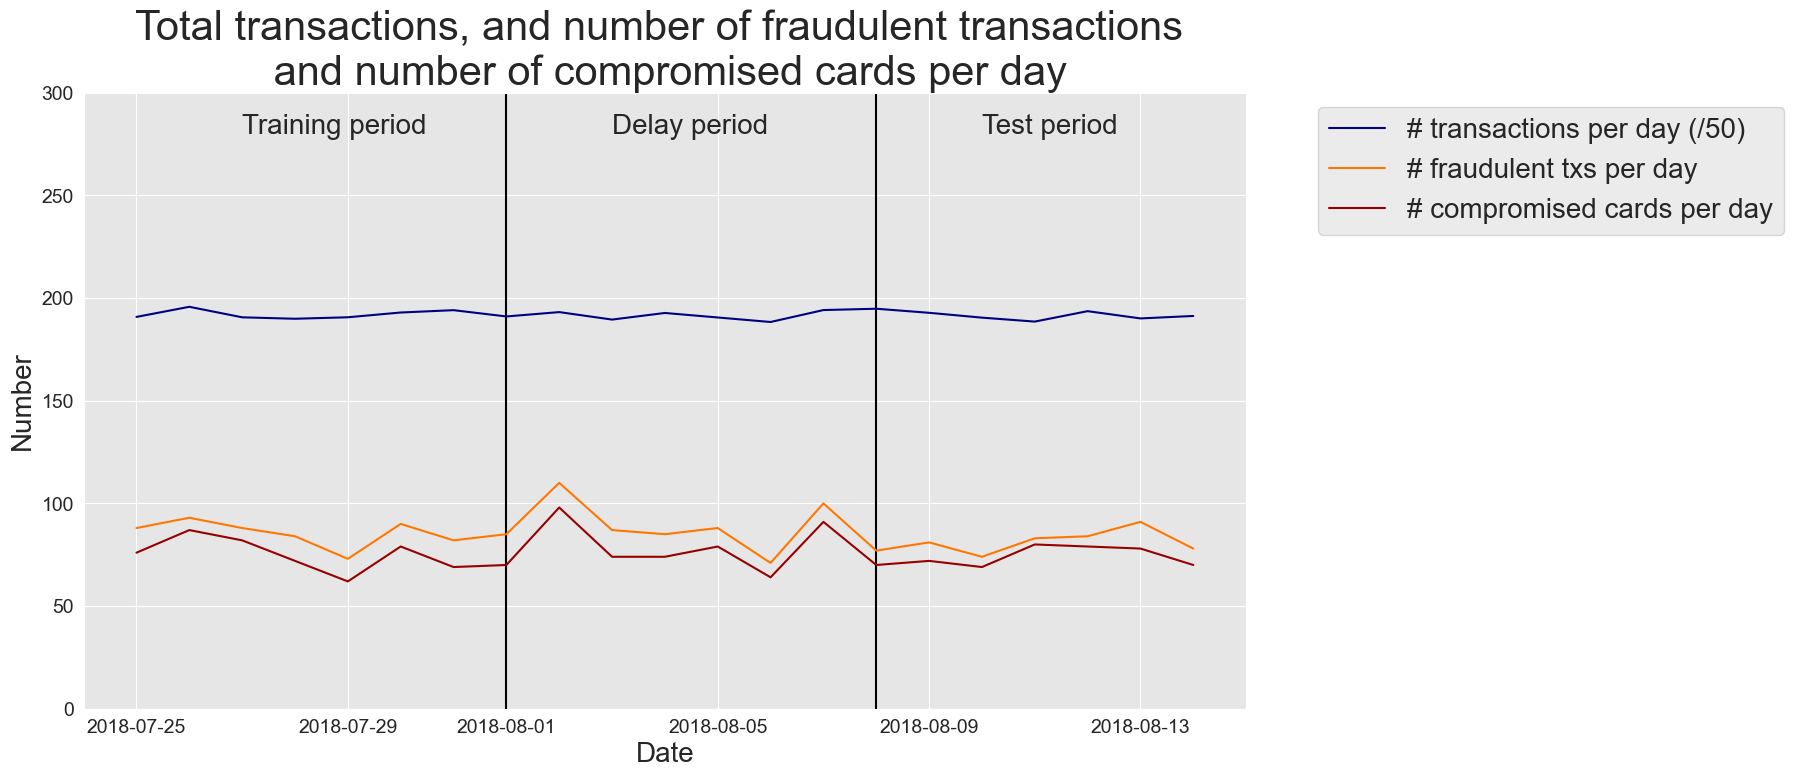

In [4]:
utils_plot_data.plot_nb_transaction_per_day(transactions_df, start_date_training, start_date_test, delta_train, delta_delay, delta_test)

In [5]:
train_df, test_df = utils_transform_data.get_train_test_set(transactions_df, start_date_training, delta_train, delta_delay ,delta_test)

In [6]:
# The trainig set contains 67240 transactions, among which 598 are fraudulent.
train_df.shape, train_df[train_df.TX_FRAUD==1].shape

((67240, 23), (598, 23))

In [7]:
#The test set contains 58264 transactions, among which 385 are fraudulent.
test_df.shape, test_df[test_df.TX_FRAUD==1].shape, f'Thus, the fraudulent transactions\'s proportion:  385/58264 = ~{(385/58264):.4f}'

((58264, 23),
 (385, 23),
 "Thus, the fraudulent transactions's proportion:  385/58264 = ~0.0066")

In [8]:
train_df.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO,TX_DURING_WEEKEND,...,CUSTOMER_ID_NB_TX_7DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW,CUSTOMER_ID_NB_TX_30DAY_WINDOW,CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW,TERMINAL_ID_NB_TX_1DAY_WINDOW,TERMINAL_ID_RISK_1DAY_WINDOW,TERMINAL_ID_NB_TX_7DAY_WINDOW,TERMINAL_ID_RISK_7DAY_WINDOW,TERMINAL_ID_NB_TX_30DAY_WINDOW,TERMINAL_ID_RISK_30DAY_WINDOW
0,1102483,2018-07-25 00:00:29,1111,2328,40.77,9936029,115,0,0,0,...,24.0,29.191250,105.0,30.141810,1.0,0.0,10.0,0.0,32.0,0.0
1,1102484,2018-07-25 00:01:08,676,6846,9.62,9936068,115,0,0,0,...,15.0,19.151333,61.0,18.253607,2.0,0.0,5.0,0.0,27.0,0.0
2,1102485,2018-07-25 00:01:35,402,4771,81.55,9936095,115,0,0,0,...,11.0,183.875455,50.0,112.001800,0.0,0.0,12.0,0.0,37.0,0.0
3,1102486,2018-07-25 00:01:43,4218,863,23.10,9936103,115,0,0,0,...,24.0,21.201667,93.0,19.987849,2.0,0.0,6.0,0.0,22.0,0.0
4,1102487,2018-07-25 00:02:26,3711,3599,59.25,9936146,115,0,0,0,...,27.0,80.427407,110.0,74.158455,1.0,0.0,10.0,0.0,38.0,0.0


In [ ]:
# Specified input features for model training and target features for predictions

output_feature = "TX_FRAUD"

input_features = ['TX_AMOUNT','TX_DURING_WEEKEND', 'TX_DURING_NIGHT', 'CUSTOMER_ID_NB_TX_1DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW', 'CUSTOMER_ID_NB_TX_7DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW', 'CUSTOMER_ID_NB_TX_30DAY_WINDOW',
       'CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW', 'TERMINAL_ID_NB_TX_1DAY_WINDOW',
       'TERMINAL_ID_RISK_1DAY_WINDOW', 'TERMINAL_ID_NB_TX_7DAY_WINDOW',
       'TERMINAL_ID_RISK_7DAY_WINDOW', 'TERMINAL_ID_NB_TX_30DAY_WINDOW',
       'TERMINAL_ID_RISK_30DAY_WINDOW']


# Only keep columns that are needed as argument to the custom scoring function
# (in order to reduce the serialization time of transaction dataset)
transactions_df_scorer = transactions_df[['CUSTOMER_ID', 'TX_FRAUD','TX_TIME_DAYS']]

card_precision_top_100 = sklearn.metrics.make_scorer(utils_training.card_precision_top_k_custom, 
                                                     needs_proba=True, 
                                                     top_k=100, 
                                                     transactions_df=transactions_df_scorer)

performance_metrics_list_grid = ['roc_auc', 'average_precision', 'card_precision@100']
performance_metrics_list = ['AUC ROC', 'Average precision', 'Card Precision@100']

scoring = {'roc_auc':'roc_auc',
           'average_precision': 'average_precision',
           'card_precision@100': card_precision_top_100,
           }